In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
from scipy import stats

# Выгрузим данные из базы в датафрейм:

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220720',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

query = '''
SELECT
    exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE
toDate(time) BETWEEN '2022-06-06' AND '2022-06-12'
AND 
exp_group BETWEEN 2 and 3
GROUP BY exp_group, user_id
'''

df = ph.read_clickhouse(query, connection=connection)

In [2]:
# Посчитаем количество пользователей в обеих группах:

df.groupby('exp_group')['user_id'].count()

exp_group
2    8480
3    8569
Name: user_id, dtype: int64

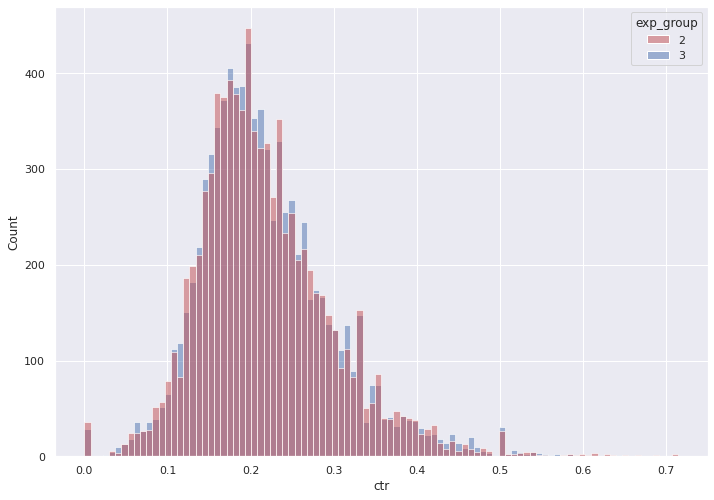

In [3]:
# Построим гистограмму, где по x - CTR, по y - частота, с которой встречаются значения CTR:

sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [4]:
# Проверим, одинаковые ли средние значения выборок, по t-критерию:

print(stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False))

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)


In [5]:
# Проверим выборки по критерию Манна-Уитни:

##print(stats.mannwhitneyu(df[df.exp_group == 2].ctr,df[df.exp_group == 3].ctr))

A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 2].ctr.sample().values[0] > df[df.exp_group == 3].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

В 48.92 % случаев A > B. Должно получиться около 50%


In [6]:
# Нагенерируем 10000 псевдовыборок без возвращения по 500 пользователей из 2 и 3 группы

#df_exp2 = df[df.exp_group == 2]
#df_exp3 = df[df.exp_group == 3]

p_values = [] #список с p-values

for i in range(10000):
    subset2 = df[df.exp_group == 2].ctr.sample(500, replace=False).tolist()
    subset3 = df[df.exp_group == 3].ctr.sample(500, replace=False).tolist()

    #print(sum(subset2) / len(subset2))
    #print(sum(subset3) / len(subset3))

    #print(stats.ttest_ind(subset2,
    #                subset3,
    #                equal_var=False))
    
    p_values.append((stats.ttest_ind(subset2,
                    subset3,
                    equal_var=False)).pvalue)

#print(p_values)

In [ ]:
# Построим диаграмму распределения полученных p-value:

sns.histplot(data = p_values)

In [8]:
# Посчитаем процент p-values, которые меньше либо равны 0.05

print(len([item for item in p_values if item <= 0.05]) / len(p_values) * 100, "%")

4.89 %


## Вывод

Если наша система корректно бьет пользователей на группы, то:
1. размеры групп примерно одинаковые;
2. показатели в них сами по себе не различаются.

В группе 2 - 10461 пользователей, в группе 3 - 10647 пользователей, что примерно одинаково.

При генерации 10000 подвыборок по 500 пользователей из обеих групп мы получили, что в только 4.89% случаев мы отвергаем гипотезу о равенстве средних этих подвыборок. То есть значимые статистические различия между группами встречаются меньше чем в 5% случаев.

Поэтому мы можем утверждать, что система сплитирования работает корректно.